In [1]:
import numpy as np 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

#data cleaning
data = pd.read_csv("/Users/nivedithaanand/Downloads/DMT Project/data.csv")
data['diagnosis'] = data['diagnosis'].map({'M':1,'B':0})
diag = data['diagnosis']
dataset = data.drop('diagnosis', axis=1)
X = dataset.iloc[:, 1:31]
X.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [2]:
#preprocessing 
import statistics
for i in list(X):
    stdS = []
    u = statistics.mean(X[i])
    s = np.std(X[i])
    for j in list(X[i]):
        #sub the mean, divide by the std
        stdS .append((j - u) / s)
    X[i] = stdS

In [68]:
import math
import copy
from numpy.linalg import norm
from sklearn import metrics

#compute l2, l1 and cosine distance matrix
def distfun(trainDF):
    trainRow = trainDF.shape[0]
    l2Matrix = np.zeros((trainRow, trainRow))
    l1Matrix = np.zeros((trainRow, trainRow))
    cosMatrix = np.zeros((trainRow, trainRow))
    for i in range(0, trainRow-1):
        for j in range(i+1, trainRow):
            #compute distmatrix by point x point
            p1 = trainDF.iloc[i]
            p2 = trainDF.iloc[j]
            #euclidean distance
            l2 = np.sqrt(np.sum(np.square(p1-p2)))
            #manhattan distance
            l1 = np.sum(np.abs(p1-p2))
            l2Matrix[i][j] = l2
            l2Matrix[j][i] = l2
            
            l1Matrix[i][j] = l1
            l1Matrix[j][i] = l1
            #cos distance = 1 - cos similarity
            cos = 1.0 - (np.dot(p1,p2)/(norm(p1)*norm(p2)))
            cosMatrix[i][j] = cos
            cosMatrix[j][i] = cos
    return l2Matrix, l1Matrix, cosMatrix

#clustering
def agnes(cindex, dist):
    #class= 2, so distance size = 2
    while(dist.shape[0]>2):
        #find minimum and locate the indices
        m = np.amin(dist[dist!=0])
        p = np.where(dist == m)
        x = p[0][0]
        y = p[1][0]
        #recompute matrix
        n = np.minimum(dist[x],dist[y])
        #print(n)
        dist[x] = n
        dist[:,y] = n
        #delete the clustered row and column
        dist = np.delete(dist, y, axis = 0)
        dist = np.delete(dist, y, axis = 1)
        #maintain index to find the clustering group
        cindex[x] = cindex[x] + cindex[y]
        cindex.pop(y)
    return cindex

def SilScore(cindex, distanceMatrix):
    SilList = []
    for k in range(0,len(cindex)):
        n = (len(cindex[k]))
        for i in range(0,len(cindex[k])):
            sumA = 0
            #same cluster
            for j in range(0,len(cindex[k])):
                if i!=j:
                    sumA +=  distanceMatrix[i][j]
                #same element
                elif i!=0 and j!=0:
                    n-=1
            a = sumA / n
            sumB = 0
            #different cluster
            z = 1 if (k==0) else 0
            for j in range(0, len(cindex[z])):
                sumB += distanceMatrix[i][j]
            b = sumB/len(cindex[z])
            Sscore = (b-a)/(max(a,b))
            if(a>b):
                Sscore = (b/a) - 1
            elif(a<b):
                Sscore = 1 - (a/b)
            SilList.append([cindex[k][i], Sscore])
    return SilList

def SilMean(cindex, SList):
    avg0 = 0
    avg1 = 0
    for k in range(0,len(cindex)): 
        s= 0
        #average for silhouette score for each point in a cluster
        for each in range(0,len(cindex[k])):
            s += SList[each][1]
        #cluster average        
        if k == 0:
            avg0 = s/len(cindex[k])
        else:
            avg1 = s/len(cindex[k])
    #average silhouette score of the both clusters
    avgS = (avg0+avg1)/2
    return avgS

def nmiScore(cindex, trainDiag):
    count = trainDiag.value_counts()
    py0 = count[0]/len(trainDiag)
    py1 = count[1]/len(trainDiag)
    hy = -py0*math.log(py0)-py1*math.log(py1)

    pc1 = len(cindex[0])/len(trainDiag)
    pc2 = len(cindex[1])/len(trainDiag)
    #entropy of the class
    hc = -pc1*math.log(pc1)-pc2*math.log(pc2)

    #get the cluster 1 for the class data with the index
    pyc1Data = trainDiag.iloc[cindex[0]]
    pyc1cnt = dict(pyc1Data.value_counts())
    if 0 not in pyc1cnt.keys():
        py2c1 = pyc1cnt[1]/len(cindex[0])
        hyc1 = -pc1 * (py2c1*math.log(py2c1))
    elif 1 not in pyc1cnt.keys():
        py1c1 = pyc1cnt[0]/len(cindex[0])
        hyc1 = -pc1 * (py1c1*math.log(py1c1))
    else:
    #classes and cluster 1
        py1c1 = pyc1cnt[0]/len(cindex[0])
        py2c1 = pyc1cnt[1]/len(cindex[0])
        hyc1 = -pc1 * (py1c1*math.log(py1c1) + py2c1*math.log(py2c1))

    #get the cluster 2, class data with the index
    pyc2Data = trainDiag.iloc[cindex[1]]
    pyc2cnt = dict(pyc2Data.value_counts())
    #classes and cluster 1
    if 0 not in pyc2cnt.keys():
        py2c2 = pyc2cnt[1]/len(cindex[1])
        hyc2 = -pc2 * (py2c2*math.log(py2c2))
    elif 1 not in pyc2cnt.keys():
        py1c2 = pyc2cnt[0]/len(cindex[1])
        hyc2 = -pc2 * (py1c2*math.log(py1c2))
    else:
        py1c2 = pyc2cnt[0]/len(cindex[1])
        py2c2 = pyc2cnt[1]/len(cindex[1])
        hyc2 = -pc2 * (py1c2*math.log(py1c2) + py2c2*math.log(py2c2))
    #nmi
    #information of the class for data points
    iyc = hy -(hyc1 + hyc2)
    nmi = (2 * iyc)/(hy + hc)
    return nmi
#test and test score
SilScoreTrain = np.zeros([10,3])
nmiTrain = np.zeros([10,3])
SilScoreTest = np.zeros([10,3])
nmiTest = np.zeros([10,3])

#k-fold calc
import math
index = []
rowcount = X.shape[0]
foldCount = math.ceil(rowcount/10)
for i in range(0, rowcount, foldCount):
    if(i+foldCount<rowcount):
        index.append(list(range(i, i+foldCount)))
    else:
        index.append(list(range(i, rowcount)))
        
#split data
for i in range(0,len(index)):
    trainIndex = index[:i] + index[i+1:]
    testIndex = index[i]
    #true label 
    testDiag = diag.iloc[testIndex]
    trainDiag = diag.drop(testIndex, axis = 0, inplace = False)
    #Data frame to work with
    testDF = X.iloc[testIndex]
    trainDF = X.drop(testIndex, axis = 0, inplace = False)
    #count
    trainRow = trainDF.shape[0]
    testRow = testDF.shape[0]
    
    #train
    l2MatrixTrain, l1MatrixTrain, cosMatrixTrain = distfun(trainDF)
    trainl2dist = copy.deepcopy(l2MatrixTrain)
    trainl1dist = copy.deepcopy(l1MatrixTrain)
    traincosdist = copy.deepcopy(cosMatrixTrain)
    
    cindex = [[each] for each in range(0,trainRow)]
    #clustering   
    cindex = agnes(cindex, trainl2dist)
    #silhouette score
    l2Label = []
    for p in range(0,(trainRow)):
        if p in cindex[0]:
            l2Label.append(0)
        else:
            l2Label.append(1)
    SilScoreTrain[i][0] = metrics.silhouette_score(l2MatrixTrain, l2Label)
    #nmi score
    nmi = nmiScore(cindex, trainDiag)
    nmiTrain[i][0]=nmi
    
    #test
    l2MatrixTest, l1MatrixTest, cosMatrixTest = distfun(testDF)
    testl2dist = copy.deepcopy(l2MatrixTest)
    testl1dist = copy.deepcopy(l1MatrixTest)
    testcosdist = copy.deepcopy(cosMatrixTest)
    
    cindex = [[each] for each in range(0,testRow)]
    #clustering   
    cindex = agnes(cindex, testl2dist)
    #silhouette score
    SList = SilScore(cindex, l2MatrixTest)
    avgS = SilMean(cindex, SList)
    l2Label = []
    for p in range(0,(testRow)):
        if p in cindex[0]:
            l2Label.append(0)
        else:
            l2Label.append(1)
    SilScoreTest[i][0] = metrics.silhouette_score(l2MatrixTest, l2Label)
    #nmi score
    nmi = nmiScore(cindex, testDiag)
    nmiTest[i][0]=nmi

    #l1 dist 
    #train
    cindex = [[each] for each in range(0,trainRow)]
    #clustering   
    cindex = agnes(cindex, trainl1dist)
    #silhouette score
    SList = SilScore(cindex, l1MatrixTrain)
    avgS = SilMean(cindex, SList)
    SilScoreTrain[i][1] = avgS
    l1Label = []
    for p in range(0,(trainRow)):
        if p in cindex[0]:
            l1Label.append(0)
        else:
            l1Label.append(1)
    SilScoreTrain[i][1] = metrics.silhouette_score(l1MatrixTrain, l1Label)
    #nmi score
    nmi = nmiScore(cindex, trainDiag)
    nmiTrain[i][1]=nmi

    
    #test
    cindex = [[each] for each in range(0,testRow)]
    #clustering   
    cindex = agnes(cindex, testl1dist)
    #silhouette score
    SList = SilScore(cindex, l1MatrixTest)
    avgS = SilMean(cindex, SList)
    l1Label = []
    for p in range(0,(testRow)):
        if p in cindex[0]:
            l1Label.append(0)
        else:
            l1Label.append(1)
    SilScoreTest[i][1] = metrics.silhouette_score(l1MatrixTest, l1Label)

    #nmi score
    nmi = nmiScore(cindex, testDiag)
    nmiTest[i][1]=nmi    
    
    #cos dist
    #train
    cindex = [[each] for each in range(0,trainRow)]
    #clustering   
    cindex = agnes(cindex, traincosdist)
    cosindex = copy.deepcopy(cindex)
    #silhouette score
    SList = SilScore(cindex, cosMatrixTrain)
    avgS = SilMean(cindex, SList)
    SilScoreTrain[i][2] = avgS
    cLabel = []
    for p in range(0,(trainRow)):
        if p in cindex[0]:
            cLabel.append(0)
        else:
            cLabel.append(1)
    SilScoreTrain[i][2] = metrics.silhouette_score(cosMatrixTrain, cLabel)
    #nmi score
    nmi = nmiScore(cindex, trainDiag)
    nmiTrain[i][2]=nmi

    #test
    cindex = [[each] for each in range(0,testRow)]
    #clustering   
    cindex = agnes(cindex, testcosdist)
    #silhouette score
    SList = SilScore(cindex, cosMatrixTest)
    avgS = SilMean(cindex, SList)
    SilScoreTest[i][2] = avgS
    cLabel = []
    for p in range(0,(testRow)):
        if p in cindex[0]:
            cLabel.append(0)
        else:
            cLabel.append(1)
    SilScoreTrain[i][2] = metrics.silhouette_score(cosMatrixTest, cLabel)
    #nmi score
    nmi = nmiScore(cindex, testDiag)
    nmiTest[i][2]=nmi    

0.7853884238347739
0.7824304433324492
0.7803954980670382
0.7805017703289154
0.778735812879409
0.7762989265175171
0.7773901674275576
0.7699625309996846
0.7676659754503099
0.7756161353695051


In [71]:
#Errorbar for silhouette score
scoreL2 = np.mean(SilScoreTest[:,0]) 
scoreL1 = np.mean(SilScoreTest[:,1]) 
scorecosine = np.mean(SilScoreTest[:,2])

scoreSDL2 = np.std(SilScoreTest[:,0]) 
scoreSDL1 = np.std(SilScoreTest[:,1]) 
scoreSDcosine = np.std(SilScoreTest[:,2]) 

Text(0.5, 1.0, 'Cross-Validation for Hyperparameter tuning using Silhouette score')

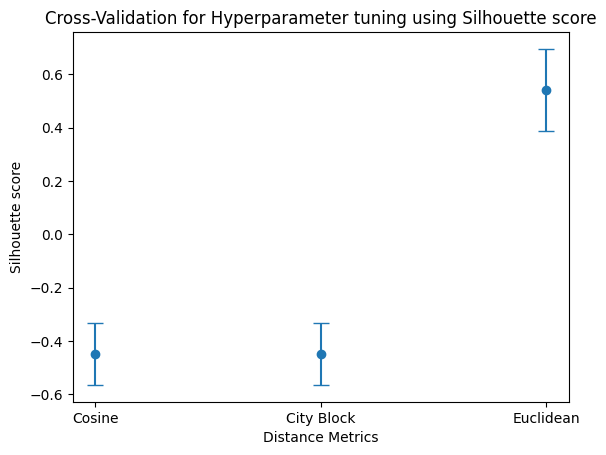

In [72]:
plt.errorbar([1,2,3],[scorecosine, scoreL1, scoreL2],yerr = [scoreSDcosine,scoreSDL1, scoreSDL2], fmt = "o", capsize = 6)
plt.xticks([1,2,3],["Cosine", "City Block","Euclidean"])
plt.ylabel("Silhouette score")
plt.xlabel("Distance Metrics")
plt.title("Cross-Validation for Hyperparameter tuning using Silhouette score")

In [73]:
#nmi errorbars
nmiCosine = np.mean(nmiTest[:,2]) 
nmiL1 = np.mean(nmiTest[:,1]) 
nmiL2 = np.mean(nmiTest[:,0]) 

nmiSDCosine = np.std(nmiTest[:,2]) 
nmiSDL1 = np.std(nmiTest[:,1]) 
nmiSDL2 = np.std(nmiTest[:,0]) 

Text(0.5, 1.0, 'Cross-Validation for Hyperparameter tuning using NMI')

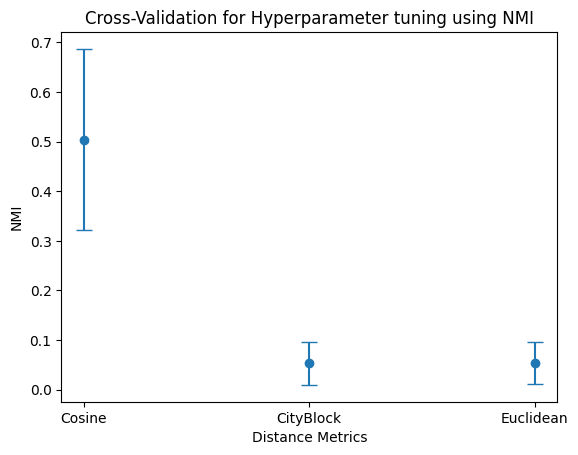

In [74]:
plt.errorbar([1,2,3],[nmiCosine, nmiL1, nmiL2],yerr = [nmiSDCosine, nmiSDL1, nmiSDL2], fmt = "o", capsize = 6)
plt.xticks([1,2,3],["Cosine","CityBlock", "Euclidean"])
plt.ylabel("NMI")
plt.xlabel("Distance Metrics")
plt.title("Cross-Validation for Hyperparameter tuning using NMI")

In [75]:
#implementation correctness 
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
#data cleaning
data = pd.read_csv("/Users/nivedithaanand/Downloads/DMT Project/implementation_correctness_dataset.csv")
data['Class/Cluster'] = data['Class/Cluster'].map({2:1, 1:0})
diag = data['Class/Cluster']
X = data.iloc[:, 0:2]
X.head()

,Feature 1,Feature 2
0,0.020,0.0
1,1.045,0.0
2,2.080,0.0
3,3.125,0.0
4,4.180,0.0


In [76]:
#data preprocessing
import statistics
for i in list(X):
    stdS = []
    u = statistics.mean(X[i])
    s = np.std(X[i])
    for j in list(X[i]):
        stdS .append((j - u) / s)
    X[i] = stdS

In [77]:
from numpy.linalg import norm
import copy

#compute euclidean distance matrix
def distfun(trainDF):
    trainRow = trainDF.shape[0]
    l2Matrix = np.zeros((trainRow, trainRow))
    for i in range(0, trainRow-1):
        for j in range(i+1, trainRow):
            #compute distance matrix
            p1 = trainDF.iloc[i]
            p2 = trainDF.iloc[j]
            #euclidean distance
            l2 = np.sqrt(np.sum(np.square(p1-p2)))
            l2Matrix[i][j] = l2
            l2Matrix[j][i] = l2
    return l2Matrix

#clustering
def agnes(cindex, dist):
    Z = []
    a =0 
    b =0
    #dendrogram clustering history 
    Zdict={}
    cluster = copy.deepcopy(cindex)
    c = len(cindex)
    #each data point is a individual cluster
    for i in range(0,c):
        Zdict[i] =  [i]
    #every point has to clustered    
    while(dist.shape[0]>1):
        #minimum value and index in the matrix
        m = np.amin(dist[dist!=0])
        p = np.where(dist == m)
        x = p[0][0]
        y = p[1][0]
        #recompute matrix
        n = np.minimum(dist[x],dist[y])
        #print(n)
        dist[x] = n
        dist[:,y] = n
        dist = np.delete(dist, y, axis = 0)
        dist = np.delete(dist, y, axis = 1)
        #dendrogram history data from dictionary 
        Zdict[c] =  cindex[x] + cindex[y]
        a = list(Zdict.keys())[list(Zdict.values()).index(cindex[x])]
        b = list(Zdict.keys())[list(Zdict.values()).index(cindex[y])]
        #maintain index to find the clustering group
        cindex[x] = cindex[x] + cindex[y]
        cindex.pop(y)
        #cluster has to two different clusters
        if(dist.shape[0]==2):
            cluster = copy.deepcopy(cindex)
        #maintain a new cluster value when we merge two data points    
        c=c+1
        Z.append([a,b,m,len(cindex[x])])
    return cluster,Z


import math
index = []
trainRow =  X.shape[0]
index.append(list(range(0, trainRow)))

l2MatrixTrain = distfun(icDF)
trainl2dist = copy.deepcopy(l2MatrixTrain)

cindex = [[each] for each in range(0,trainRow)]
#clustering 
#clustered index and Z id the matrix for dendrogram
cindex,Z = agnes(cindex, trainl2dist)
#clustered index
print(cindex)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], [14, 15, 16]]


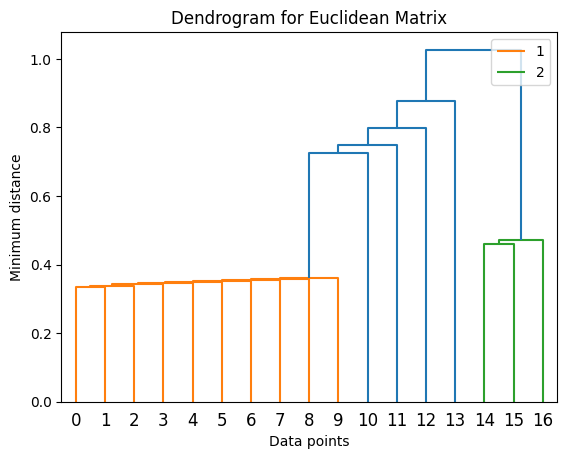

In [82]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram,linkage
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform

#linkage_matrix = linkage(l2MatrixTrain, "single")
dendrogram(Z)
plt.xlabel("Data points")
plt.ylabel("Minimum distance")
plt.legend([1,2])
plt.title("Dendrogram for Euclidean Matrix")
plt.show()

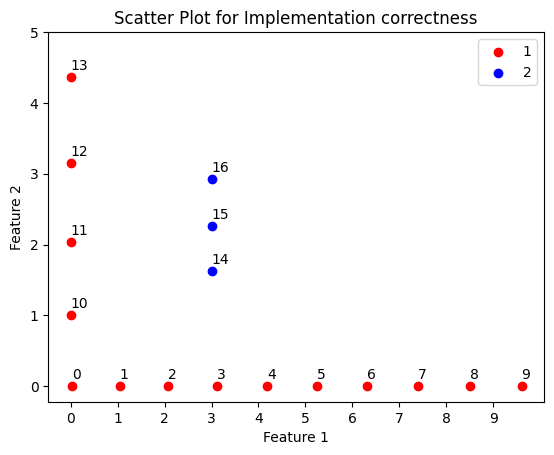

In [79]:
C1 = data.iloc[l2[0]]
C2 = data.iloc[l2[1]]
#cluster 1
plt.scatter(C1.iloc[:,0], C1.iloc[:,1], c = "red")
#cluster 2
plt.scatter(C2.iloc[:,0], C2.iloc[:,1], c = "blue")
plt.xticks(np.arange(0,10,1))
plt.yticks(np.arange(0,6,1))
plt.title("Scatter Plot for Implementation correctness")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend([1,2])
for i in range(0,(data.shape[0])):
    #integers on aboove the points
    plt.annotate(i, (data.iloc[i][0], data.iloc[i][1]+0.1))